## Introduction: Classification with Neural Networks

So far, we have used neural networks to predict continuous values - a task called regression. But many real-world problems require predicting categories instead: Is this email spam or not? Which digit is written in this image? What stimulus was presented to the animal?

In this notebook, we turn to classification, where the goal is to assign inputs to discrete categories. A central challenge in classification is identifying clusters in data and learning decision boundaries that separate them. When data points from different classes form distinct clusters, a classifier must learn where one cluster ends and another begins. For linearly separable clusters, a simple linear model suffices. But real data often contains clusters with complex shapes that no straight line can separate.

We start by examining how linear models fail when clusters cannot be separated by a straight line, then show how adding nonlinearity through activation functions enables neural networks to learn curved decision boundaries that correctly identify which cluster each data point belongs to.

From there, we introduce loss functions designed specifically for classification. Unlike regression, where we measure distance from a target value, classification requires measuring how confident the model is in predictions across discrete categories.

Finally, we apply these ideas to real neuroscience data, training a classifier to identify which visual stimulus was presented to a mouse based on recorded neural activity.

## Setup

### Import Libraries

In [3]:
import copy

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.datasets import make_blobs

from ipywidgets import interact, IntSlider
import owncloud
import xarray as xr

from sklearn.svm import SVC

### Utility Functions

In [48]:
def train(model: nn.Module, features: torch.Tensor, labels: torch.Tensor, nepochs: int = 100) -> None:

    loss_function = nn.CrossEntropyLoss()
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.1)
    for epoch in range(nepochs):
        optimizer.zero_grad()
        output = model.forward(features)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

def calculate_accuracy(model: nn.Module, features: torch.Tensor, labels: torch.Tensor, verbose = True) -> torch.Tensor: 

    output = model(features)
    accuracy = (labels == torch.argmax(output, dim=1)).sum()/len(labels)
    if verbose:
        print(f'Accuracy: {(accuracy*100).item()}')
    return (accuracy*100).item()

def do_binary_classification_interactive(model, X, labels, nepochs=40, step_size = 1, optimizer_class = optim.RMSprop):
    """Interactive binary classification with epoch slider"""

    loss_function=nn.BCEWithLogitsLoss()

    # store initial model state to reset before training
    initial_state = copy.deepcopy(model.state_dict())

    def train_and_plot(epoch_to_show):
        # reset model to initial state
        model.load_state_dict(copy.deepcopy(initial_state))
        optimizer = optimizer_class(model.parameters(), lr=0.1)

        # Train up to the selected epoch
        for epoch in range(epoch_to_show + 1):
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_function(y_pred.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # Plot the result at this epoch
        with torch.no_grad():
            y_pred = model(X)
            probs = torch.sigmoid(y_pred)

            # Create meshgrid for decision boundary
            x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                                 np.linspace(y_min, y_max, 200))
            grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
            grid_preds = torch.sigmoid(model(grid_points)).reshape(xx.shape)

        plt.figure(figsize=(6, 5))
        plt.title(f"epoch={epoch_to_show}, loss={loss.item():.4f}")
        
        # Plot decision boundary as a contour line at probability = 0.5
        plt.contour(xx, yy, grid_preds.numpy(), 'k--', levels=[0.5], linewidths=2, linestyles='dashed')
        
        plt.scatter(*X.T, s=20, c=(probs > 0.5).squeeze(), cmap='Set1')
        plt.show()


    # Create slider
    epoch_slider = IntSlider(min=0, max=nepochs, step=step_size, value=0, description='Epoch:')
    interact(train_and_plot, epoch_to_show=epoch_slider)

def generate_clusters_nonlinear_classification(n_samples=256, noise=0.1, random_state=42):
    """Generate and plot two interleaving moon-shaped clusters with decision boundary."""
    features_orig, labels_orig = make_moons(n_samples, noise=noise, random_state=random_state)
    features = torch.tensor(features_orig, dtype=torch.float32)
    labels = torch.tensor(labels_orig, dtype=torch.long)

    # Fit SVM to approximate the true decision boundary
    svm = SVC(kernel='rbf', C=10, gamma='scale')
    svm.fit(features_orig, labels_orig)

    # Create meshgrid for decision boundary
    x_min, x_max = features[:, 0].min() - 0.5, features[:, 0].max() + 0.5
    y_min, y_max = features[:, 1].min() - 0.5, features[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.scatter(*features.T, s=20, c=labels, cmap='Dark2')
    plt.contour(xx, yy, Z, levels=[0], colors='black', linestyles='dashed', linewidths=2)
    plt.title('Clusters with a Non-Linear Decision Boundary')
    plt.xlim(-1.5, 2.5)
    plt.ylim(-1, 1.5)
    
    return features, labels


class utils:
    train = train
    calculate_accuracy = calculate_accuracy
    do_binary_classification_interactive = do_binary_classification_interactive
    generate_clusters_nonlinear_classification = generate_clusters_nonlinear_classification


### Download Data

In [5]:
Path('data').mkdir(exist_ok=True, parents=True)

owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/QdABQ7tHCfM52CH').get_file('/', f'data/spike_count_and_stimulus_type_per_trial.pt')

True

## Section 1: Separating Clusters with Non-Linear Separation Boundary

Classification problems often involve separating data points that belong to different classes. When these classes form distinct clusters, the classifier must learn a **decision boundary** that separates them. For some datasets, a simple straight line (or hyperplane in higher dimensions) is sufficient - these are called **linearly separable** problems. A single linear layer can solve these easily.

However, many real-world datasets have clusters that no straight line can separate. These require **non-linear decision boundaries**. The solution is to introduce non-linearity into our network using **activation functions** like ReLU. By stacking linear layers with activation functions between them, neural networks can learn complex, curved decision boundaries that correctly classify points even when clusters have intricate shapes.

| Code | Description |
| --- | --- |
| `nn.Linear(n_features_in, n_features_out)` | A single layer of nodes (neurons) that takes in `n_features_in` input features and outputs `n_features_out` features.|
| `nn.ReLU()` | Creates a rectified linear unit (ReLU) activation function.|
| `nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(1,10),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(10,1)`<br>`)` | Creates a container where layers and activation functions are stacked in a sequential order. This ensures that the input is passed through the network in that order.|
| `utils.do_binary_classification(model, X, labels)` | Do binary classification. `X` is the input data and `labels` are the true class labels for the data. |
| `utils.do_binary_classification(model, X, labels, epochs=200)` | Do binary classification and set the number of epochs to 200. |

Run cell below to generate data for **linear** binary classification

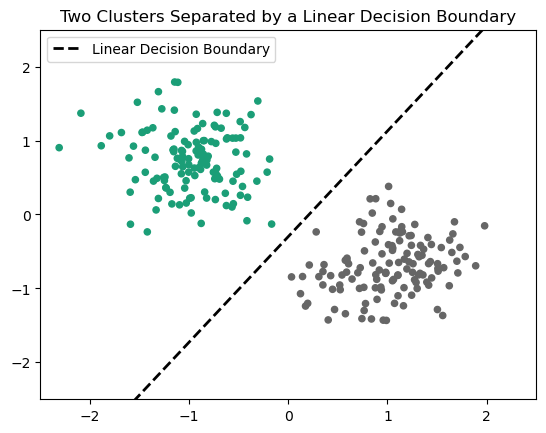

In [6]:
# generate two linearly separable clusters
features_linear, labels_linear = make_blobs(
    n_samples=256, 
    centers=[[-1, 0.7], [1, -0.7]],
    cluster_std=0.4,
    random_state=2026
)
features_linear = torch.tensor(features_linear, dtype=torch.float32)
labels_linear = torch.tensor(labels_linear, dtype=torch.long)

plt.scatter(*features_linear.T, s=20, c=labels_linear, cmap='Dark2');
plt.title('Two Clusters Separated by a Linear Decision Boundary');

# Add illustration of decision boundary line (perpendicular bisector of the line connecting centers)
x_line = np.linspace(-2.5, 2.5, 100)
y_line = x_line / 0.7 - 0.3  # passes through origin with slope 1/0.7
plt.plot(x_line, y_line, 'k--', linewidth=2, label='Linear Decision Boundary')

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.legend();

**Exercise**: Run the cell below to create a linear model with 2 input features and 1 output feature and pass this model as input to the function `utils.do_binary_classification_interactive`. Drag the slider to train the model. Is this model able to classify points in the two clusters correctly after training?

In [7]:
# create model
torch.manual_seed(2026)
model = nn.Linear(2,1)

utils.do_binary_classification_interactive(model, features_linear, labels_linear)

interactive(children=(IntSlider(value=0, description='Epoch:', max=40), Output()), _dom_classes=('widget-inter…

Run cell below to generate data for **non-linear** binary classification

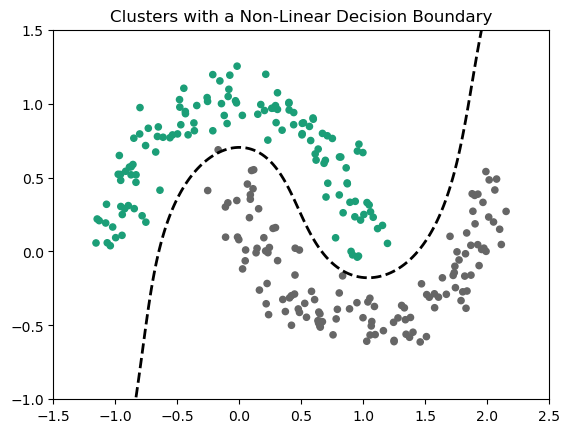

In [8]:
features, labels = utils.generate_clusters_nonlinear_classification()

**Exercise**: Create a linear model with 2 input features and 1 output feature and assign it to a variable named `model`. Then, run the cell that makes the interactive plot that shows the models classification of the two clusters throughout training. Drag the slider to train the model. Is this model able to classify points in the two clusters correctly after training?

In [10]:
utils.do_binary_classification_interactive(model, features, labels)

interactive(children=(IntSlider(value=0, description='Epoch:', max=40), Output()), _dom_classes=('widget-inter…

**Exercise**: Use the same model to do binary classification but this time, try increasing the number of epochs (no need to go beyond 200). Is the model able to do the classification correctly now?

Even if the result might have improved a little bit, the linear model isn't able to correctly classify all points, no matter how many epochs we train the model for. The reason for this is that the boundary separating the two classes of points is *non-linear*, and a linear model will never be able to capture a non-linear boundary. 

Models will only be able to solve non-linear problems if we add non-linearity to the model. Activation functions, which we learnt about in the previous session, provide such non-linearity.

**Exercise**: Create a model composed of two layers with a rectified linear unit (ReLU) activation function between them. Assign it to a variable named `model`. Then, run the cell that makes the interactive plot that shows the models classification of the two clusters throughout training. Drag the slider to train the model. Is the model able to correctly classify all the points now?

In [13]:
utils.do_binary_classification_interactive(model, features, labels, nepochs=100)

interactive(children=(IntSlider(value=0, description='Epoch:'), Output()), _dom_classes=('widget-interact',))

## Section 2: Different Problems Require Different Kinds of Loss Functions

In the previous sessions, we've used mean squared error (MSE) as our loss function. MSE works well for regression problems, where we're trying to predict a continuous value like a firing rate or a price. But not all machine learning problems are regression problems. In classification problems, we're trying to predict which category something belongs to - for example, whether an image shows a cat or a dog, or which type of stimulus was presented to the animal in an experiment. For these problems, MSE doesn't work well because we're not measuring distance from a target value, we're measuring how confident the model is in its class prediction. PyTorch provides different loss functions for different types of problems:

- **MSE Loss** (`nn.MSELoss()`): For regression - predicting continuous values
- **Binary Cross-Entropy** (`nn.BCEWithLogitsLoss()`): For binary classification - two classes
- **Cross-Entropy** (`nn.CrossEntropyLoss()`): For multiclass classification - more than two classes

In all cases, the loss measures how wrong the model's predictions are. Lower loss means better predictions, and training a neural network means finding parameters that minimize the loss.

| Code | Description |
| --- | --- |
| `nn.MSELoss()` | Creates a mean squared error (MSE) loss function. Used for regression problems. |
| `nn.BCEWithLogitsLoss()` | Creates a binary cross-entropy loss function. Used for binary classification (two classes). |
| `nn.CrossEntropyLoss()` | Creates a cross-entropy loss function. Used for multiclass classification (more than two classes). |
| `loss_function = nn.CrossEntropyLoss()` | Assign `nn.CrossEntropyLoss()` to a variable named `loss_function`. |
| `loss_function(model_output, labels)` | Calculates the loss between predictions `y_pred` and true values `y_true`. |
| `loss_function(model_output, labels).item()` | Extracts the loss value as a `float` from the tensor. |

**Example**: Create a binary cross-entropy loss function using PyTorch's `nn` module.

In [14]:
nn.BCEWithLogitsLoss()

BCEWithLogitsLoss()

**Exercise**: Create a binary cross-entropy loss function using PyTorch's `nn` module and assign it to a variable named `loss_function`. Display the variable.

**Exercise**: Create a cross-entropy loss function for multiclass classification using PyTorch's `nn` module and assign it to a variable named `loss_function`. Display the variable.

Below we simulate a binary classification scenario. Imagine we have a model that predicts whether a neuron is "active" (1) or "inactive" (0) based on some input. The model outputs a raw score (called a "logit"). Positive values suggest "active", negative values suggest "inactive". Run the cell to print the output of the model (the raw score) and the true labels.

In [33]:
# simulated model outputs (logits) for 4 samples
# Positive values = model thinks "active", negative = model thinks "inactive"
model_output = torch.tensor([2.0, -1.0, 0.5, -2.0])

# True labels: 1 = active, 0 = inactive
labels_true = torch.tensor([1.0, 0.0, 1.0, 0.0])

print(f"Model predictions (logits): {model_output}")
print(f"True labels: {labels_true}")

Model predictions (logits): tensor([ 2.0000, -1.0000,  0.5000, -2.0000])
True labels: tensor([1., 0., 1., 0.])


**Example**:  Calculate the binary cross-entropy loss for the model prediction above.

In [34]:
# create the binary cross-entropy loss function
loss_function = nn.BCEWithLogitsLoss()
# calculate binary cross-entropy loss
loss = loss_function(model_output, labels_true)

print(f"Binary cross-entropy loss: {loss.item():.4f}")

Binary cross-entropy loss: 0.2603


**Exercise**: The cell below contains a different set of predictions for the same true labels. The model made worse predictions this time (the signs of the logits don't match the true labels as well). Calculate the binary cross-entropy loss. Is the loss higher or lower than in the example above?

In [35]:
# bad predictions - signs often don't match true labels
model_output = torch.tensor([-1.0, 1.0, -0.5, 1.0])

# True labels (same as before)
labels_true = torch.tensor([1.0, 0.0, 1.0, 0.0])

Below, we simulate multiclass classification. For multiclass classification, the model outputs a score for each possible class. Our hypothetical model that classifies images into 3 categories indicating where the stimulus was presented: "stimulus left" (0), "stimulus middle" (1), or "stimulus right" (2). The model outputs 3 scores per sample - higher scores indicate higher confidence in that class.

In [37]:
# model outputs for 3 samples, with 3 classes each (stimulus left, stimulus middle, stimulus right)
# each row is one sample, each column is the score for one class
model_output = torch.tensor([
    [2.0, 0.5, -1.0],   # Sample 1: highest score for stimulus left (index 0)
    [-1.0, 2.5, 0.0],   # Sample 2: highest score for stimulus middle (index 1)
    [0.0, -0.5, 3.0]    # Sample 3: highest score for stimulus right (index 2)
])

# true labels (class indices): stimulus left=0, stimulus middle=1, stimulus right=2
labels_true = torch.tensor([0, 1, 2])

print(f"Model predictions (logits):\n{model_output}")
print(f"True labels: {labels_true}")

Model predictions (logits):
tensor([[ 2.0000,  0.5000, -1.0000],
        [-1.0000,  2.5000,  0.0000],
        [ 0.0000, -0.5000,  3.0000]])
True labels: tensor([0, 1, 2])


**Example**: Calculate the cross-entropy loss for the simulated data above.

In [ ]:
# calculate cross-entropy loss
loss_function = nn.CrossEntropyLoss()
loss = loss_function(model_output, labels_true)

print(f"Cross-entropy loss: {loss.item():.4f}")

**Exercise**: The cell below contains predictions where the model made some mistakes (the highest scores don't always match the true labels). Calculate the cross-entropy loss for these predictions. Is the loss higher or lower than in the example?

In [39]:
# bad predictions - highest scores don't match true labels
model_output = torch.tensor([
    [0.5, 2.0, -1.0],   # Sample 1: highest score for stimulus middle, but true label is stimulus left
    [-1.0, 2.5, 0.0],   # Sample 2: highest score for stimulus middle (correct)
    [2.0, -0.5, 1.0]    # Sample 3: highest score for stimulus left, but true label is stimulus right
])

# True labels (same as before)
labels_true = torch.tensor([0, 1, 2])

## Section 3: Understanding The Classification Accuracy Equation

What you may have noticed in the previous section is that output of the network was not a class label. The model output is set of scores (one score for each class) that reflects the networks belief that a data point belongs to each of the classes. To get the output in the form of a class guess by the network, we have to determine which class has the highest score. That gives us the model's predicted class.

This predicted class can then compared to the true class in `labels` to calculate the accuracy. The accuracy is related to the loss, but it's not the same thing, and is often calculated in addition to the loss because it gives us a number between 0 and 100 % which is easier to directly interpret in terms of model performance. Here, you'll learn how to calculate the accuracy.

| Code | Description |
| --- | --- |
| `torch.argmax(x, dim=1)` | Finds the index at which `x` has the highest value along its dimension 1. |
| `a == b` | Compares each element of the tensors (or arrays) `a` and `b` and returns a tensor of boolean (`True` or `False`) values indicating which elements are the same (`True`) and different (`False`). |
| `(a == b).sum()` or `torch.sum(a == b)`| Sums all elements where the condition `a == b` is `True`. `True` is counted as 1, `False` as 0. |
| `(a == b).sum() / len(a)` | Calculates proportion of elements in `a` where the element is equal to the corresponding element in `b`.|

Run the two cells below to first generate the data with two clusters and a nonlinear decision boundary and then define a model to classify the points as belonging to each of the clusters.

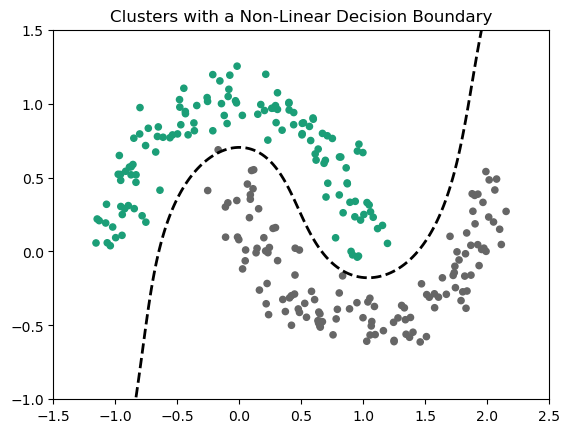

In [73]:
features, labels = utils.generate_clusters_nonlinear_classification()

In [74]:
torch.manual_seed(2026)
# create model
model = nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,2)
)

**Example**: Run the first cell below to get the model's raw output scores for the nonlinear clusters data. The output has shape `(256, 2)` - one row per sample, with 2 scores (one per cluster). Then, use `torch.argmax` to find which class has the highest score for each sample. Assign the result to a variable named `predicted_labels`.

In [75]:
# Get model predictions
with torch.no_grad():
    output = model(features)

print(f'Output shape: {output.shape}')
print(f'First 5 rows of output:\n{output[:5]}')

Output shape: torch.Size([256, 2])
First 5 rows of output:
tensor([[-0.0772, -0.6854],
        [-0.0935, -0.4184],
        [ 0.0317, -0.1809],
        [ 0.0017, -0.5337],
        [ 0.0530, -0.1375]])


In [76]:
predicted_labels = torch.argmax(output, dim=1)
predicted_labels[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Exercise**: Compare the predicted labels to the true labels using `==`. The result is a tensor of boolean values (`True` where the prediction is correct, `False` where it is wrong).

**Exercise**: Use `.sum()` on the comparison result to count how many predictions are correct. (`True` counts as 1 and `False` counts as 0.)

**Exercise**: Calculate the accuracy by dividing the number of correct predictions by the total number of labels.

**Exercise**: (Optional) Multiply the number you got in the previous exercise by 100 to express it as a percentage.

50 % accuracy with only two classes is what you would expect by random guessing, so not very good.

Run the cell below to train the model for 50 epochs and then get the model's raw output scores. 

In [81]:
utils.train(model, features, labels, nepochs=50)

# Get model predictions
with torch.no_grad():
    output = model(features)

print(f'Output shape: {output.shape}')
print(f'First 5 rows of output:\n{output[:5]}')

Output shape: torch.Size([256, 2])
First 5 rows of output:
tensor([[-2.3167,  1.8567],
        [-0.2996,  0.3400],
        [ 1.8239, -1.5800],
        [-5.2590,  4.7205],
        [ 3.6754, -4.0560]])


**Exercise**: Use `torch.argmax` to find which cluster has the highest score for each trial - which cluster does the model believe that each data point belongs to. Assign the result to a variable named `predicted_labels`.

**Exercise**: Compare the predicted labels to the true labels using `==`. The result is a tensor of boolean values (`True` where the prediction is correct, `False` where it is wrong).

**Exercise**: Calculate the accuracy by dividing the number of correct predictions by the total number of labels.

**Exercise**: (Optional) Multiply the number you got in the previous exercise by 100 to express it as a percentage.

## Section 4: Classify Stimulus Information from Neural Spike Data

In the previous sections, we saw how neural networks can capture non-linear decision boundaries using synthetic data. Now let's apply the same approach to real neuroscience data. The task of the neural network is to predict **which kind of visual stimulus was presented** to a mouse based on the activity of neurons recorded during the experiment. It should classify whether the stimulus to the left or right had higher contrast, or if the two of them had equal contrast. This is a three-class classification problem.

| Code | Description |
| :-- | :-- |
| `nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(n_features, 64),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(64, 3)`<br>`)` | Creates a neural network with one hidden layer (64 nodes) and ReLU activation for 3-class classification. |
| `nn.CrossEntropyLoss()` | Creates a cross-entropy loss function for multiclass classification. |
| `losses = []` | Initialize an empty list to stores the loss values. |
| `losses.append(loss.item())` | Stores the loss value in a list. |
| `utils.calculate_accuracy(model, features, labels)` | Calculates the accuracy of the model on the given data. |

The features and labels that the model will be trained on have already been extracted from the dataset. 

The labels are class labels - they tell you which stimulus class was presented in a trial. **Label 0**: contrast left, **label 1**: contrast is equal, **label 2**: contrast right. These make out the targets that the model predictions are compared to to assess how well the model is performing. There are `261` labels, one for each trial.

The features are the **spike counts** of each (real biological) cell in each trial. There are `1268` cells and in the dataset, which means that there are `1268` features for the model to train on and use to make its prediction about the stimulus type presented in a given trial.

Run the cell below to load and take a look at the dimensions of data and the content of `labels`.

In [86]:
data = torch.load('data/spike_count_and_stimulus_type_per_trial.pt')

features = data['features']
labels = data['labels']

print(f'Number of trials: {features.shape[0]}')
print(f'Number of cells: {features.shape[1]}')
print(f'len(labels): {len(labels)}')
print(f'labels: {labels}')

Number of trials: 261
Number of cells: 1268
len(labels): 261
labels: tensor([0, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0,
        0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1,
        1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 0, 0,
        2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 2,
        0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 2, 2, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2,
        0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
        0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2,
        2, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2,
        1, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2])


**Exercise**: Create a neural network model with one hidden layer and a ReLU activation function. The number of input features in the model should match the number of features in the dataset (`1268`), the hidden layer should have 64 nodes, and the output layer should have 3 nodes (one per stimulus class). The ReLU activation function should come directly after the hidden layer. Assign the model to a variable named `model` and display it.

In [104]:
n_features = 1268

**Example**: Let's see how well the model performs before training. Run the cell below to create the model and make a prediction by passing the features to the model and calculate the loss. Then, calculate the accuracy using the utility function `utils.calculate_accuracy` and print the loss and the accuracy.

In [106]:
# create model
torch.manual_seed(2026)
model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

# create optimizer for model 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# create loss function
loss_fn = nn.CrossEntropyLoss()

# pass the input to the model and get a prediction
model_pred = model(features)

# calculate the loss
loss = loss_fn(model_pred, labels)

In [107]:
accuracy = utils.calculate_accuracy(model, features, labels, verbose=False)
print(f"Epoch {0}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

Epoch 0, Loss: 1.9130, Accuracy: 22.9885


**Exercise**: Run the cell below to train the model for one epoch. Then, calculate the accuracy using the utility function `utils.calculate_accuracy` and print the loss and the accuracy.

In [108]:
for epoch in range(1):
    # reset the gradients
    optimizer.zero_grad()

    # pass the input to the model
    model_pred = model(features)

    # calculate the loss
    loss = loss_fn(model_pred, labels)

    # perform backward propagation to calculate the gradients
    loss.backward()

    # update the parameters
    optimizer.step()

**Exercise**: Run the cell below to train the model for 10 epochs. Then, calculate the accuracy using the utility function `utils.calculate_accuracy` and print the loss and the accuracy.

In [110]:
for epoch in range(10):
    # reset the gradients
    optimizer.zero_grad()

    # pass the input to the model
    model_pred = model(features)

    # calculate the loss
    loss = loss_fn(model_pred, labels)

    # perform backward propagation to calculate the gradients
    loss.backward()

    # update the parameters
    optimizer.step()

In [111]:
accuracy = utils.calculate_accuracy(model, features, labels, verbose=False)
print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

Epoch 9, Loss: 0.9766, Accuracy: 54.0230


**Example**: Add a line to store the loss in each epoch in a variable named `losses`. Then, run the first cell to train the model over 20 epochs and the second cell to visualize the loss over epochs.

In [ ]:
# create model
torch.manual_seed(2026)
model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

# create optimizer for model 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# initialize list to store loss
losses = []
for epoch in range(20):
    # reset the gradients
    optimizer.zero_grad()

    # pass the input to the model
    model_pred = model(features)

    # calculate the loss
    loss = loss_fn(model_pred, labels)

    # perform backward propagation to calculate the gradients
    loss.backward()

    # update the parameters
    optimizer.step()

    # store loss in this epoch
    losses.append(loss.item())

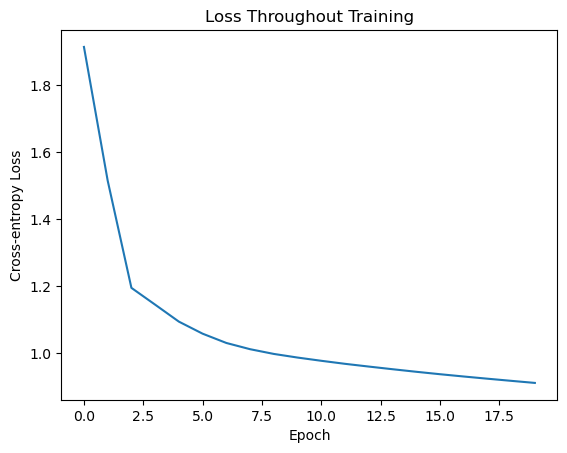

In [99]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy Loss')
plt.title('Loss Throughout Training');

**Exercise**: Add a line to store the loss in each epoch in a variable named `losses`. Then, run the first cell to train the model over 100 epochs and the second cell to visualize the loss over epochs.

In [ ]:
# create model
torch.manual_seed(2026)
model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

# create optimizer for model 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


___ # UPDATE ME: initialize list to store loss
for epoch in range(100):
    # reset the gradients
    optimizer.zero_grad()

    # pass the input to the model
    model_pred = model(features)

    # calculate the loss
    loss = loss_fn(model_pred, labels)

    # perform backward propagation to calculate the gradients
    loss.backward()

    # update the parameters
    optimizer.step()

    
    ___ # UPDATE ME: store loss in this epoch

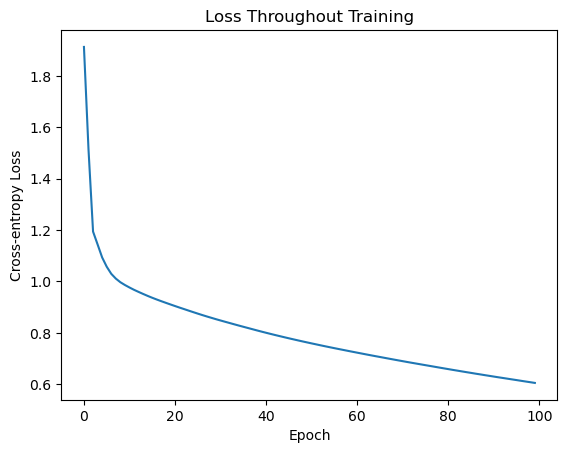

In [102]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy Loss')
plt.title('Loss Throughout Training');

**Exercise**: Calculate the accuracy of the model trained above using `utils.calculate_accuracy`.

The model achieves over 78% accuracy on the training data (it could probably reach higher accuracies too if we trained it for longer). But does this mean it has truly learned to decode neural activity, or has it simply memorized the training examples? To answer this question, we need to evaluate the model on data it has never seen before. We'll learn how to do this properly on Day 2 when we will cover train/test splitting and overfitting.